In [1]:
# Import the necessary libraries
import os.path
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import scipy.sparse
from itertools import groupby
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
import spacy
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.stem.lancaster import LancasterStemmer
from collections import Counter

In [2]:
# Read in the train, test, and sample submission data from the 'data' directory
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')
train1 = train

In [3]:
# Select all columns from the third column onwards in the train DataFrame
x=train.iloc[:,2:].sum()
rowsums=train.iloc[:,2:].sum(axis=1)

# Add a new column to the train DataFrame called 'nontoxic' that contains a boolean value indicating
# whether or not the comment is toxic
train['nontoxic']=(rowsums==0)

In [4]:
# Create a new column called "istoxic" in the "train" data frame
# if a value in the "nontoxic" column is True, the corresponding value in the
# "istoxic" column will be False, and vice versa
train['istoxic'] = ~train['nontoxic']
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,False


In [5]:
# Display the first 10 rows of the "train" data frame using the head() method
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,True,False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,True,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,True,False
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,True,False


In [6]:
# From now on data frame called "train" will contain only 
# the "id", "comment_text", and "istoxic" columns from the original "train" data frame
train = train[['id', 'comment_text', 'istoxic']]
train1 = train #To keep this DataFrame for another model
train.head(10)

,id,comment_text,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False
9,00040093b2687caa,alignment on this subject and which are contra...,False


## TfidfVectorizer

The vectorizer is initialized with the following parameters:

- ngram_range: The range of n-grams to be extracted from the documents. In this case, only unigrams (single words) are extracted.
- max_features: The maximum number of features (i.e., unique words) to be extracted from the documents. In this case, only the most frequent 10,000 words will be used.
- min_df: The minimum number of documents that a word must appear in to be included in the matrix. In this case, a word must appear in at least 2 documents to be included.
- max_df: The maximum proportion of documents that a word can appear in to be included in the matrix. In this case, a word can appear in at most 70% of the documents.
- strip_accents: A flag that specifies whether to remove accent marks from the words in the documents. In this case, accent marks are removed.
- analyzer: The type of tokens (i.e., words, characters, or subwords) to be extracted from the documents. In this case, only words are extracted.
- stop_words: The list of stop words (i.e., common words that are not useful for text analysis) to be removed from the documents. In this case, the default English stop words list is used.

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000, min_df=3, max_df=0.99,
                             strip_accents='unicode', analyzer='word', stop_words = None)
vectorizer.fit(train['comment_text'])
featurenames = vectorizer.get_feature_names()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
X = vectorizer.transform(train['comment_text'])
y = train['istoxic']

In [9]:
print(train['comment_text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [10]:
# Train-test split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=21)

## Basic Model

To begin with, this model uses a basic principle: Those who exceed the 200 word threshold are labeled as 'toxic', and those who fall under labelled as 'non-toxic'

In [11]:
train1.head(10)

,id,comment_text,istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False
9,00040093b2687caa,alignment on this subject and which are contra...,False


In [12]:
label = train[['istoxic']]
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    y[ix][0] = l

In [13]:
print(y)

[[264.]
 [112.]
 [233.]
 ...
 [ 81.]
 [116.]
 [189.]]


In [14]:
train1['len']=y

In [15]:
train1.head(10)

,id,comment_text,istoxic,len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,264.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,112.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,233.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,622.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,67.0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False,65.0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True,44.0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False,115.0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False,472.0
9,00040093b2687caa,alignment on this subject and which are contra...,False,70.0


In [16]:
train1['_istoxic']=train1['len']>200.0

In [17]:
train1.head(10)

,id,comment_text,istoxic,len,_istoxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,264.0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,112.0,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,233.0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,622.0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,67.0,False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False,65.0,False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True,44.0,False
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False,115.0,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False,472.0,True
9,00040093b2687caa,alignment on this subject and which are contra...,False,70.0,False


In [18]:
confusion_matrix = metrics.confusion_matrix(train1['istoxic'], train1['_istoxic'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

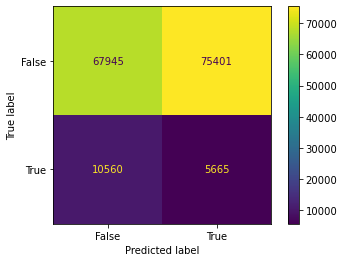

In [19]:
cm_display.plot()
plt.show()

In [20]:
print('Precision: %.3f' % precision_score(train1['istoxic'], train1['_istoxic']))

Precision: 0.070


In [21]:
print('Recall: %.3f' %  recall_score(train1['istoxic'], train1['_istoxic']))

Recall: 0.349


In [22]:
print('Accuracy: %.3f' % accuracy_score(train1['istoxic'], train1['_istoxic']))

Accuracy: 0.461


In [23]:
print('F1 Score: %.3f' % f1_score(train1['istoxic'], train1['_istoxic']))

F1 Score: 0.116


## Logistic Regression

In [24]:
model = LogisticRegression()

model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [25]:
y_pred_test = model.predict(X_test)
y_pred_test

array([False, False, False, ..., False, False, False])

In [26]:
y_pred_train = model.predict(X_train)

In [27]:
model.coef_

array([[-0.07591614, -0.43100053, -0.05416171, ...,  0.34690096,
        -0.08603851,  0.82099104]])

**Prediction Scores**

In [28]:
proba = model.predict_proba(X_test)[:, [1]]

In [29]:
mean_absolute_error(proba, y_test)

0.07555912118496344

In [30]:
metrics.mean_squared_error(proba, y_test, squared=True)

0.03326672254411145

In [31]:
np.mean(y_pred_train == y_train)

0.9605278471606729

In [32]:
np.mean(y_pred_test == y_test)

0.9551930147058824

In [33]:
f1_score(y_test, y_pred_test)

0.7380632555867627

## Hyperparameter Table

TfidfVectorizer is a class in the scikit-learn library that can be used to transform a collection of raw documents into a matrix of TF-IDF features. The analyzer and stop_words parameters are two optional parameters that you can use to customize the way the vectorizer processes the text in your documents.

The analyzer parameter determines how the vectorizer should analyze the text in your documents. You can choose to use the "word" analyzer, which tokenizes the text by words, or the "char" analyzer, which tokenizes the text by characters. You can also provide your own custom analyzer by passing a function that takes in a string and returns a list of tokens.

The stop_words parameter allows you to specify a list of words to be excluded from the vocabulary of the vectorizer. These words are often called "stop words" because they are common words that do not convey much meaning and can be removed from the text without affecting its overall content. You can pass a list of stop words to the stop_words parameter, or you can use one of the pre-defined stop word lists provided by scikit-learn.

In [ ]:
# Since it takes a long time to process the codes in this cell,
# you can access the results that I ran and saved as .csv from the DataFrame below.

# The scores will go here
results = []

# Models to train
models = ['KNN', 'RandomForest', 
          'AdaBoost']

# Define the model parameters
p_n_neighbors = list(range(1, 6))
p_max_depth = [1,10,100,200,500]
p_n_estimators = [100,200,500,1000,2000]

# Define the TF-IDF Vectorizer parameters (sparse matrises are created and saved to disk in advance)
paths = ['data/sparse_matrix.npz','data/sparse_matrix1.npz','data/sparse_matrix2.npz']
analyzers = ['word', 'word', 'char_wb']
p_stop_words =['english', 'none', 'none']

# For loop to create a hyperparameter table
for path, analyzer, stop_words in zip(paths, analyzers, p_stop_words):
    y = train['istoxic']
    X = scipy.sparse.load_npz(path)
    # Train-test split
    X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=21)
    for i in models:
        if i == 'KNN':
            for n_neighbors in p_n_neighbors:
                # Train the model
                model = KNeighborsClassifier(n_neighbors=n_neighbors)
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                # Append current results
                results.append({
                    'Analyzer': analyzer,
                    'Parameter': n_neighbors,
                    'Stop_words': stop_words,
                    'Model': i,
                    'Train Accuracy': round(accuracy_score(y_train, y_pred_train), 5),
                    'Test Accuracy': round(accuracy_score(y_test, y_pred_test), 5),
                    'Test F1 Score': f1_score(y_train, y_pred_train),
                    'Train F1 Score': f1_score(y_test, y_pred_test)
                })
        elif i == 'RandomForest':
            for max_depth in p_max_depth:
                # Train the model
                model = RandomForestClassifier(max_depth=max_depth)
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                # Append current results
                results.append({
                    'Analyzer': analyzer,
                    'Parameter': max_depth,
                    'Stop_words': stop_words,
                    'Model': i,
                    'Train Accuracy': round(accuracy_score(y_train, y_pred_train), 5),
                    'Test Accuracy': round(accuracy_score(y_test, y_pred_test), 5),
                    'Test F1 Score': f1_score(y_train, y_pred_train),
                    'Train F1 Score': f1_score(y_test, y_pred_test)
                })
        else:
            for n_estimators in p_n_estimators:
                # Train the model
                model = AdaBoostClassifier(n_estimators=n_estimators)
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                # Append current results
                results.append({
                    'Analyzer': analyzer,
                    'Parameter': n_estimators,
                    'Stop_words': stop_words,
                    'Model': i,
                    'Train Accuracy': round(accuracy_score(y_train, y_pred_train), 5),
                    'Test Accuracy': round(accuracy_score(y_test, y_pred_test), 5),
                    'Train F1 Score': f1_score(y_train, y_pred_train),
                    'Test F1 Score': f1_score(y_test, y_pred_test)
                })

# Convert to Pandas DataFrame and sort descendingly by accuracy
results = pd.DataFrame(results)
results = results.sort_values(by='Test F1 Score', ascending=False)
results

In [3]:
hyperparametertable = pd.read_csv('data/hyperparametertable.csv')
hyperparametertable

,,Analyzer,Parameter,Stop_words,Model,Train Accuracy,Test Accuracy,Test F1 Score,Train F1 Score
0,24,word,500,none,RandomForest,0.99962,0.95095,0.998138,0.700128
1,15,word,1,none,KNN,0.99962,0.91565,0.998095,0.425441
2,0,word,1,english,KNN,0.99670,0.41105,0.983836,0.220299
3,30,char_wb,1,none,KNN,0.99670,0.41105,0.983836,0.220299
4,23,word,200,none,RandomForest,0.99640,0.95081,0.981884,0.698734
5,39,char_wb,500,none,RandomForest,0.99244,0.95557,0.961242,0.759253
6,9,word,500,english,RandomForest,0.99231,0.95546,0.960518,0.757617
7,38,char_wb,200,none,RandomForest,0.98321,0.95521,0.909538,0.750349
8,8,word,200,english,RandomForest,0.98315,0.95546,0.909161,0.749765
9,31,char_wb,2,none,KNN,0.97924,0.41580,0.888343,0.211375


In [ ]:
# Create a TfidfVectorizer object, which is a tool used to convert
# a collection of raw documents into a matrix of numerical values that represent
if not os.path.isfile('data/sparse_matrix.npz'):
    vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000, min_df=3, max_df=0.99, 
                             strip_accents='unicode', analyzer='word', stop_words = 'english')
    vectorizer.fit(train['comment_text'])
    featurenames = vectorizer.get_feature_names()

In [ ]:
if os.path.isfile('data/sparse_matrix.npz'):
    X = scipy.sparse.load_npz('data/sparse_matrix.npz')
    featurenamesdf = pd.read_csv('data/featurenamesdf.csv')
else:
    X = vectorizer.transform(train['comment_text'])
    scipy.sparse.save_npz('data/sparse_matrix.npz', X)
    featurenames = vectorizer.get_feature_names()
    featurenamesdf = pd.DataFrame(featurenames)
    featurenamesdf.to_csv('data/featurenamesdf.csv')
y = train['istoxic']